# **Auto Encoders (and two variations)**



*   https://arxiv.org/pdf/2003.05991.pdf
*   https://deepai.org/machine-learning-glossary-and-terms/manifold-hypothesis
*   https://en.wikipedia.org/wiki/Latent_space
*   https://avandekleut.github.io/vae/
*   https://www.youtube.com/watch?v=rZufA635dq4&t=1413s
*   https://stats.stackexchange.com/questions/455560/why-is-the-mean-and-log-variance-specified-as-the-output-of-an-inference-network
*   https://arxiv.org/pdf/1711.00937.pdf



Auto encoders are unsupervised neural networks that learn to reduce data dimensions to efficiently compress data and reconstruct it. 

They are generally composed of two different parts, the encoder, which compresses the input *x* into a latent space, and a decoder that reconstructs the data back into an output *xhat*. The goal is to minimize the loss between the input *x* and the output *xhat*. 


## Auto Encoders

The [manifold hypothesis](https://deepai.org/machine-learning-glossary-and-terms/manifold-hypothesis) states that many high level data is actually low level data embedded in high dimensional space. That means data that exists in many dimensions can actually be represented in a much more simple way. For example, a sphere can be viewed as an infinite number of points that exist in a fixed distance from its center in 3d, each with their own three dimensional coordinates. However, a sphere can also be represented as just a center and a radius, reducing the potential large amount of data to just two data points. 

This is the core idea of autoencoders. The encoder portion reduces the dimensionality of the input into the [latent space](https://en.wikipedia.org/wiki/Latent_space) and the decoder uses the compressed data to reconstruct back into the output. The latent space is the dimensional space that is used for the latent vector, which is the lower dimensional representation of the input *x*. Since the dimensionality of the latent space is the smallest in the entire model, it is also known as the '[bottleneck](https://avandekleut.github.io/vae/)' of the model. 

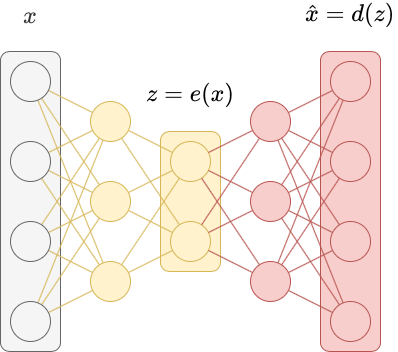

The encoder learns a nonlinear transformation *e* and the decoder learns a nonlinear transformation *d* such that the latent *z* is

*z* = *e*(*x*)

and the reconstructed *xhat* is

*xhat* = *d*(*z*) = *d*(*e*(*x*))

An autoencoder is the composition of the encoder and decoder and the output of the encoder is the input of the decoder. That means the function *f* of the autoencoder is the same as *d*(*e*) 

The autoencoder can be trained end-to-end, which means that the entire model is trained as a whole. To be more specific, the loss function that is back propagated is applied to the entire autoencoder model. An advantage of training end-to-end is that it is simpler to train rather than training the encoder and decoder components separately. This also means we only need to use one loss function for the entire model. For an autoencoder, this means we can use the reconstruction loss between *xhat* and *x*, such as the MSELoss between each pixel of the output and input. Since the loss function applies to the whole model and depends on both the encoder and decoder simultaneously, both components are being optimized for each other too. 

The goal is to force the autoencoder model to fit data through the bottleneck, so that the autoencoder learns the most significant patterns in the data. Due to this restriction, some information may be lost, but the latent vector contains crucial data and is much smaller than the input.

### Model

#### Setup

In [ ]:
'''
from google.colab import drive
drive.mount('/content/drive')

%cd "/content/drive/MyDrive/Colab Notebooks/cse353-final/final"
%ls
'''

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/cse353-final/final
353_blogpost.ipynb  data/  models/


In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
#plt.rcParams['figure.dpi'] = 100

import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Encoder and Decoder
---
Both the encoder and decoder use three convolutional layers because they are well suited to extract spatial information and patterns from the image data. We then use a fully connected layer to learn significant representations based on the spatial information. 

We arbitrarily chose the number of hidden layers and latent dimensions.

In [ ]:
class ae_encoder(nn.Module):
    def __init__(self, in_channels, num_hidden, latent_dims):
        super(ae_encoder, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=num_hidden//2, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=num_hidden//2, out_channels=num_hidden, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=num_hidden, out_channels=num_hidden, kernel_size=3, stride=1, padding=1)

        self.fc4 = nn.Linear(8192, latent_dims)
    
    def forward(self, inputs):
        x = F.relu(self.conv1(inputs))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, start_dim=1)
        return self.fc4(x)

class ae_decoder(nn.Module):
    def __init__(self, in_channels, num_hidden, latent_dims):
        super(ae_decoder, self).__init__()

        self.fc1 = nn.Linear(latent_dims, 8192)

        self.convT2 = nn.ConvTranspose2d(in_channels=num_hidden, out_channels=num_hidden, kernel_size=3, stride=1, padding=1)
        self.convT3 = nn.ConvTranspose2d(in_channels=num_hidden, out_channels=num_hidden//2, kernel_size=4, stride=2, padding=1)
        self.convT4 = nn.ConvTranspose2d(in_channels=num_hidden//2, out_channels=in_channels, kernel_size=4, stride=2, padding=1)

    def forward(self, inputs):
        x = F.relu(self.fc1(inputs))
        x = x.view(-1, 128, 8, 8)
        x = F.relu(self.convT2(x))
        x = F.relu(self.convT3(x))
        return self.convT4(x)


#### Autoencoder model
---
The autoencoder is the composition of the encoder and decoder. 

We use the MSE loss (squared l2 norm) function as our loss function. 

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dims, num_hidden):
        super(Autoencoder, self).__init__()

        self.encoder = ae_encoder(3, num_hidden, latent_dims)
        self.decoder = ae_decoder(3, num_hidden, latent_dims)
    
    def forward(self, inputs):
        xhat = self.decoder(self.encoder(inputs))
        return xhat, self.loss_func(inputs, xhat)

    def loss_func(self, x, xhat):
        return nn.MSELoss(reduction='sum')(x, xhat)
        

In [ ]:
def train_autoencoder(model, data_loader, epochs, opt=None):
    if opt is None:
        opt = torch.optim.Adam(model.parameters())
    for epoch in range(epochs):
        train_loss = 0
        for idx, data in enumerate(data_loader):
            x, _ = data
            x = x.to(device)

            xhat, loss = model(x)
            train_loss += loss.item()

            opt.zero_grad()
            loss.backward()
            opt.step()

            if idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch+1,
                    idx * len(x),
                    len(data_loader.dataset),
                    100. * idx / len(data_loader),
                    loss.item() / len(x)))
        print('====> Epoch: {} Average loss: {:.6f}'.format(
            epoch+1, train_loss / len(data_loader.dataset)))

### Hyperparameters

In [ ]:
batch_size = 256
epochs = 100

num_hidden = 128
latent_dims = 512

ae_PATH = 'ae_cifar10'

In [ ]:
data_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR10(
        root="./data", train=True, download=True,
        transform=torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))
            ])
        ), batch_size=batch_size, shuffle=True, pin_memory=True)


Files already downloaded and verified


### Run model

In [ ]:
model = Autoencoder(latent_dims, num_hidden).to(device)
if os.path.isfile('./models/' + ae_PATH):
    model.load_state_dict(torch.load('./models/' + ae_PATH))
else:
    train_autoencoder(model, data_loader, epochs)
    torch.save(model.state_dict(), './models/' + ae_PATH)

### Result

Loss: tensor(8.2589, device='cuda:0', grad_fn=<MseLossBackward0>)


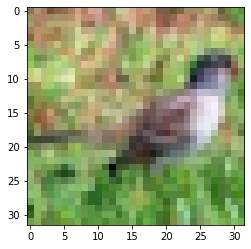

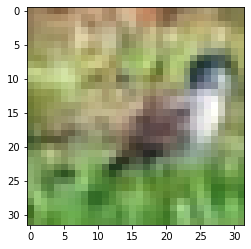

In [ ]:
(original, _) = next(iter(data_loader))
original = original[0].to(device)

x = original.cpu()
xhat, loss = model(original[None,:])
print('Loss:', loss)

plt.imshow(np.transpose(x, (1,2,0))+0.5)
plt.show()
plt.imshow(np.transpose(xhat[0].cpu().detach().numpy(), (1,2,0))+0.5)
plt.show()

Here we can see a comparison between the input image *x* and output image *xhat*. Due to forcing the model to lower the dimensionality through a bottleneck, the reconstructed output keeps the general patterns at the cost of the details on edges, however that does not seem to be an issue for a dataset like CIFAR10, which already uses a small number of dimensions per data sample (latent variable is about 1/6 the size of the input). 

## Variational Autoencoder (VAE)

To generate new data, one could assume we can just give the decoder component of the autoencoder a random latent variable and it would reconstruct the output such that it uses previously trained patterns to turn the random latent variable into an actual image. However, the autoencoder had no incentive to regularize the latent variables it generated. This means that the latent variables it constructed when training could be irregular, so a new random latent variable could make no sense.

Below is an [example](https://avandekleut.github.io/vae/) of an autoencoder trained on the MNIST dataset using a latent space with two dimensions so it can be plotted on an (x, y) graph.

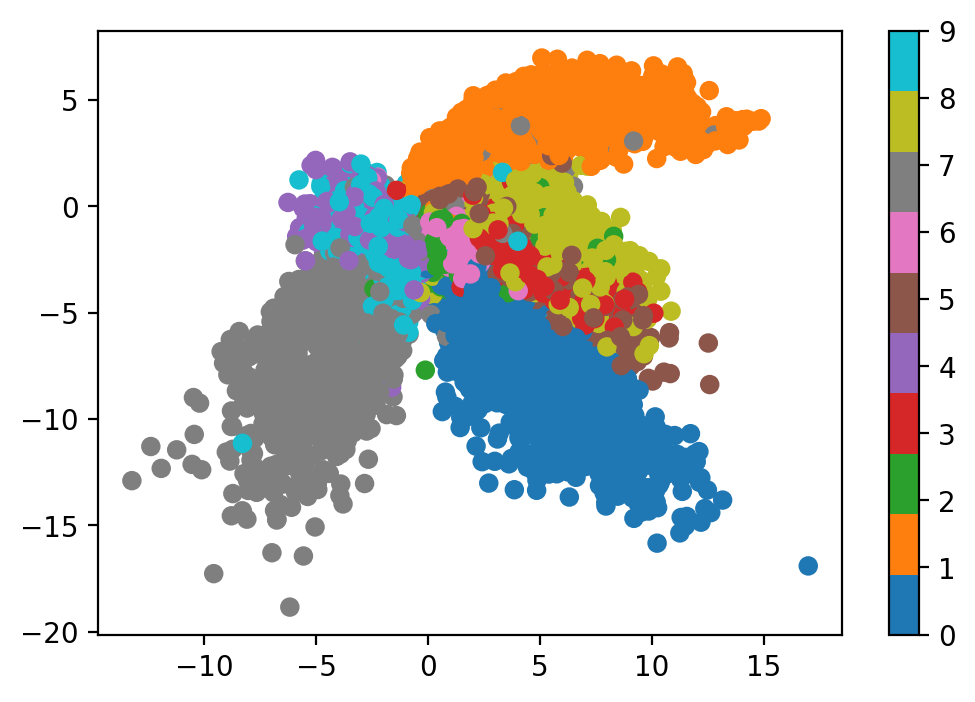

The graph shows that the author's autoencoder did not construct its latent variables in a regular fashion. To specify, many of the plotted latent variables formed clumps that branched out of the origin, and the origin is not the median of the latent variables. This means that for example, if we randomly give it a latent variable of (-5, 5), their autoencoder would not be able to create an output digit that resembles any real digit, as the autoencoder has never seen a latent variable at that location. 

This behavior should be expected since the autoencoder had no reason to make its latent representation of data to be regular; the only thing the loss function penalized it for was to make the output similar to the input, so the autoencoder was only incentivized to encode and decode with as little loss between *x* and *xhat* as possible. Downsides of this is that it would be difficult to generate new data, since there are regions of unused latent space, and that it can be prone to overfitting, since the autoencoder can just separate classes far from each other.

A variational autoencoder (VAE) is one possible solution to make the latent space more regularized. A VAE attempts to solve the problem by having a loss function that encourages regularization and has a latent space that is more friendly with the generation of new data. This is achieved by the following: 


1.   The input is encoded as a [distribution](https://avandekleut.github.io/vae/) over the latent space
2.   A random point is sampled from the distribution
3.   That sampled point is decoded and used for the loss function
4.   Backpropagate that loss function

 

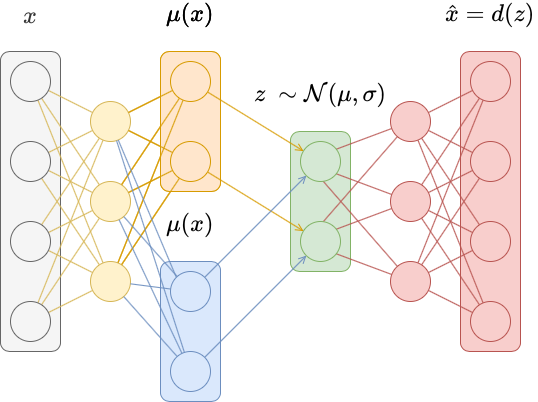

We represent the latent variable as a distribution instead of a point to make the latent space continuous. Since it is continuous, generating based on a random latent variable would make more sense since the latent space is based on probabilities, so being closer to a class's distribution means it is more likely to be a part of that class. 

Our loss function also reflects this. Instead of relying solely on MSELoss, we now add a new metric called KL Divergence. MSELoss ensures local regularization by making sure our latent variable's variance stays low, since if it is high, a randomly sampled point would be far from the center and would be different from the actual input. KL Divergence measures how different two probability distributions are. We use the KL Divergence to find the difference between our latent space and the normal distribution. This incentivizes our VAE to try to group the classes around the normal distribution, ensuring global regularization. This combination of a 'reconstruction term' and 'regularization term' makes our latent space group data points of the same class together, while also making sure the different groups are still close to the normal distribution. 

Below is another example from the same website as the previous image of a VAE implemented as above on the MNIST dataset.

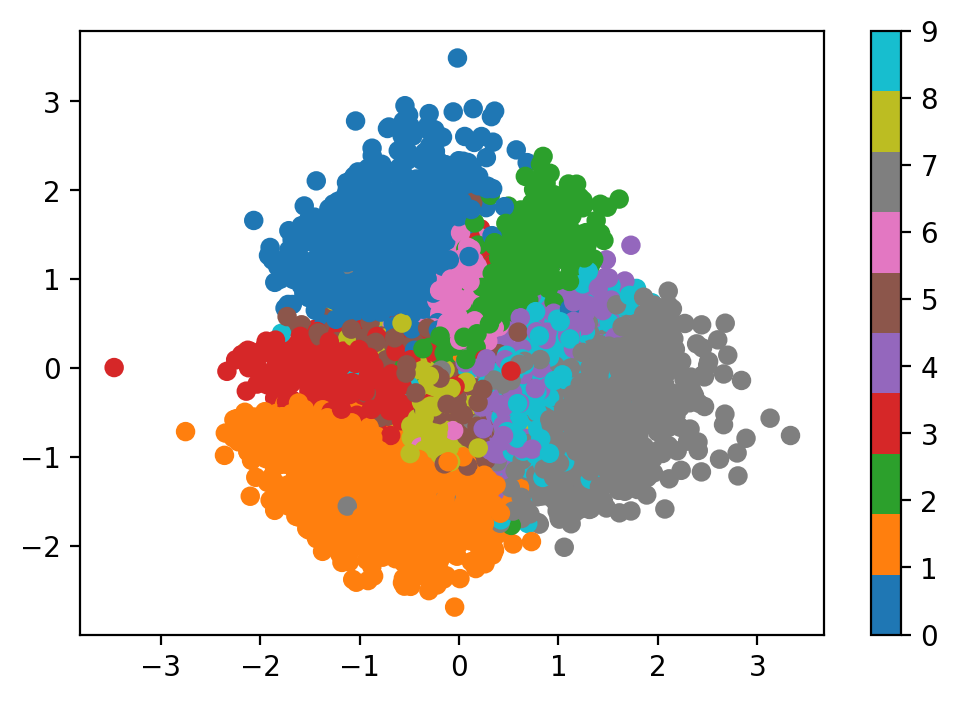

An important aspect of VAEs to mention is the reparameterization trick. Normally we backpropagate loss through our model, but since we are randomly sampling our point, we can not backpropagate end-to-end since there is a stochastic node. 

[As shown in the diagram](https://youtu.be/rZufA635dq4?t=1413), we can solve this problem by introducing the stochastic variable epsilon. This means that instead of using a stochastic sample from our distribution, we use a deterministic sample based on a stochastic distribution. This allows us to still find the gradient of our latent variable since our latent variable is now deterministic with respect to epsilon, and epsilon is separate from the model. We can then use the gradient of the latent variable to calculate the gradient of the distribution and continue to train end-to-end. 

(My way of understanding this is if we are playing darts, you can't find the gradient of the points I get, but you can find the gradient of the points function that is multiplied by my random throwing)


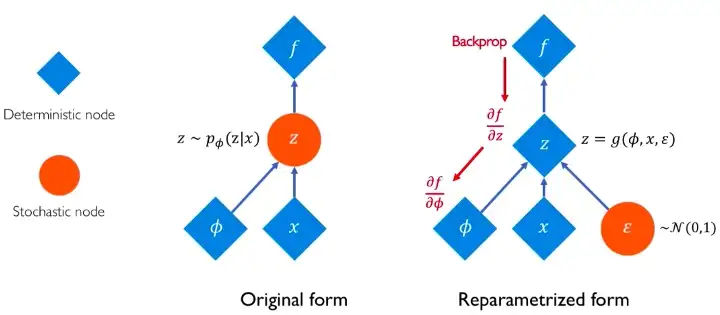

### Model

#### Setup

In [ ]:
'''
from google.colab import drive
drive.mount('/content/drive')

%cd "/content/drive/MyDrive/Colab Notebooks/cse353-final/final"
%ls
'''

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/cse353-final/final
353_blogpost.ipynb  data/  models/


In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
#plt.rcParams['figure.dpi'] = 100

import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Encoder, Decoder, and the Reparameterization trick


In [ ]:
class vae_encoder(nn.Module):
    def __init__(self, in_channels, num_hidden, latent_dims):
        super(vae_encoder, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=num_hidden//2, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=num_hidden//2, out_channels=num_hidden, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=num_hidden, out_channels=num_hidden, kernel_size=4, stride=2, padding=1)

        #self.fc4 = nn.Linear(2048, 1024)
        self.fc_mu = nn.Linear(2048, latent_dims)
        self.fc_logvar = nn.Linear(2048, latent_dims)
    
    def forward(self, inputs):
        x = F.relu(self.conv1(inputs))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, start_dim=1)
        #x = F.relu(self.fc4(x))
        return self.fc_mu(x), self.fc_logvar(x)

class vae_decoder(nn.Module):
    def __init__(self, in_channels, num_hidden, latent_dims):
        super(vae_decoder, self).__init__()

        self.fc1 = nn.Linear(latent_dims, 2048)
        #self.fc2 = nn.Linear(1024, 2048)

        self.convT3 = nn.ConvTranspose2d(in_channels=num_hidden, out_channels=num_hidden, kernel_size=4, stride=2, padding=1)
        self.convT4 = nn.ConvTranspose2d(in_channels=num_hidden, out_channels=num_hidden//2, kernel_size=4, stride=2, padding=1)
        self.convT5 = nn.ConvTranspose2d(in_channels=num_hidden//2, out_channels=in_channels, kernel_size=4, stride=2, padding=1)

    def forward(self, inputs):
        x = F.relu(self.fc1(inputs))
        #x = F.relu(self.fc2(x))
        x = x.view(-1, 128, 4, 4)
        x = F.relu(self.convT3(x))
        x = F.relu(self.convT4(x))
        return self.convT5(x)

#### VAE Model
---
$KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}$

Our encoder and decoder use the same three convolutional layers as the autoencoder, but we now use two fully connected layers to learn how to best calculate the probability distribution of the input data. 

The reparameterization trick lies in the reparameterize(mean, [logvar](https://stats.stackexchange.com/questions/455560/why-is-the-mean-and-log-variance-specified-as-the-output-of-an-inference-network)) function.

In [ ]:
class VAEModel(nn.Module):
    def __init__(self, latent_dims, num_hidden):
        super(VAEModel, self).__init__()

        self.encoder = vae_encoder(3, num_hidden, latent_dims)
        self.decoder = vae_decoder(3, num_hidden, latent_dims)

    def reparameterize(self, mu, logvar):
        """
        Reparameterization trick to allow backpropagation with the sampled latent vector

        remember logvar is log variance, so to get standard deviation need to do e^(0.5*logvar)
        """
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + (std * eps)
    
    def forward(self, inputs):
        mu, logvar = self.encoder(inputs)
        z = self.reparameterize(mu, logvar)
        xhat = self.decoder(z)

        loss = self.loss_func(inputs, xhat, mu, logvar)
        return xhat, loss

    def loss_func(self, x, xhat, mu, logvar):
        recon_loss = nn.MSELoss(reduction='sum')(x, xhat)
        kl_div = torch.mul(-0.5, torch.sum(1 + logvar - mu**2 - logvar.exp()))
        return recon_loss + kl_div
        

In [ ]:
def train_vae(model, data_loader, epochs, opt=None):
    if opt is None:
        opt = torch.optim.Adam(model.parameters())
    for epoch in range(epochs):
        train_loss = 0
        for idx, data in enumerate(data_loader):
            x, _ = data
            x = x.to(device)

            xhat, loss = model(x)
            train_loss += loss.item()

            opt.zero_grad()
            loss.backward()
            opt.step()

            if idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch+1,
                    idx * len(x),
                    len(data_loader.dataset),
                    100. * idx / len(data_loader),
                    loss.item() / len(x)))
        print('====> Epoch: {} Average loss: {:.6f}'.format(
            epoch+1, train_loss / len(data_loader.dataset)))

### Hyperparameters

In [ ]:
batch_size = 256
epochs = 100

num_hidden = 128
latent_dims = 512

vae_PATH = 'vae_cifar10'

In [ ]:
data_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR10(
        root="./data", train=True, download=True,
        transform=torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))
            ])
        ), batch_size=batch_size, shuffle=True, pin_memory=True)


Files already downloaded and verified


### Run model

In [ ]:
model = VAEModel(latent_dims, num_hidden).to(device)
if os.path.isfile('./models/' + vae_PATH):
    model.load_state_dict(torch.load('./models/' + vae_PATH))
else:
    train_vae(model, data_loader, epochs)
    torch.save(model.state_dict(), './models/' + vae_PATH)

### Result

Loss: tensor(119.8970, device='cuda:0')


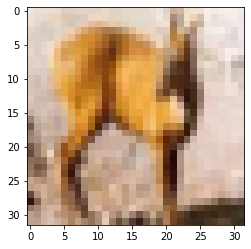

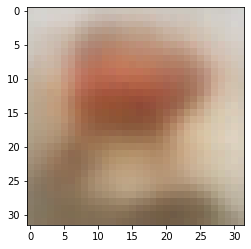

In [ ]:
(original, _) = next(iter(data_loader))
original = original[0].to(device)

x = original.cpu()

mu, logvar = model.encoder(original[None,:])
xhat = model.decoder(model.reparameterize(mu, logvar))[0].cpu()
print('Loss:', model.loss_func(x, xhat, mu, logvar).detach())

plt.imshow(np.transpose(x, (1,2,0))+0.5)
plt.show()
plt.imshow(np.transpose(xhat.detach().numpy(), (1,2,0))+0.5)
plt.show()

As shown in the picture above, the output image is significantly worse than the output image from the autoencoder. This could be because the VAE was not able to overfit like the autoencoder and so is less accurate, but the VAE is also more friendly towards the generation of new images. Because the latent space is continuous, the images will not be as sharp as the autoencoder, since every point would be in a probability field of other latent variables. 

This continuous latent space would make generating novel images easier because any random latent vector given would be within the viable space of the model, since the model is incentivized by the KL Divergence to clump around the normal distribution. This means that random latent vector inputs would be reasonably nearby other latent vector's probabilities, so while the output would not be as precise as the outputs of the autoencoder, it would resemble an existing class even if the model has not seen the latent vector before. 

## Vector Quantized Variational Autoencoder (VQVAE)

VAEs are good for learning continuous features, but some tasks that we wish to use neural network models for are inherently not discrete. For example, training on language would not make sense for a continuous model or classification problems. For example, when describing words based on how close words are together, 'can' and 'car' are only 1 letter off from another, but in a language context they mean entirely different things. If used in a word vector approach, 'car' and 'truck' may have similar usages and so may have vectors that are close, but they still mean different things that may not make sense when the words are interchanged. Classification problems can also make use of discrete representations, as a model may get rain data and calculate '70% chance to rain' but a person would just think to get an umbrella. 

A new ([2018](https://arxiv.org/pdf/1711.00937.pdf)) model called the vector quantised-variational autoencoder (VQVAE) attempts to solve this problem by using vector quantization to train. Instead of depending on a normal distribution, the VQVAE uses quantized vectors from a 'codebook' dictionary.


The encoder encodes an input to produce *z_e*, but instead of representing that as a distribution, the model calculates the closest discrete latent variable *z* from a list of them called the 'codebook'. That closest codebook vector is then fed into the decoder. 


1.   The encoder converts the input to *z_e* through convolutional layers
2.   *z_e* is used to calculate the nearest neighbor inside the embedding space codebook and encoded as a one hot vector
3.   That nearest neighbor latent vector is put into the decoder which produces the output image.



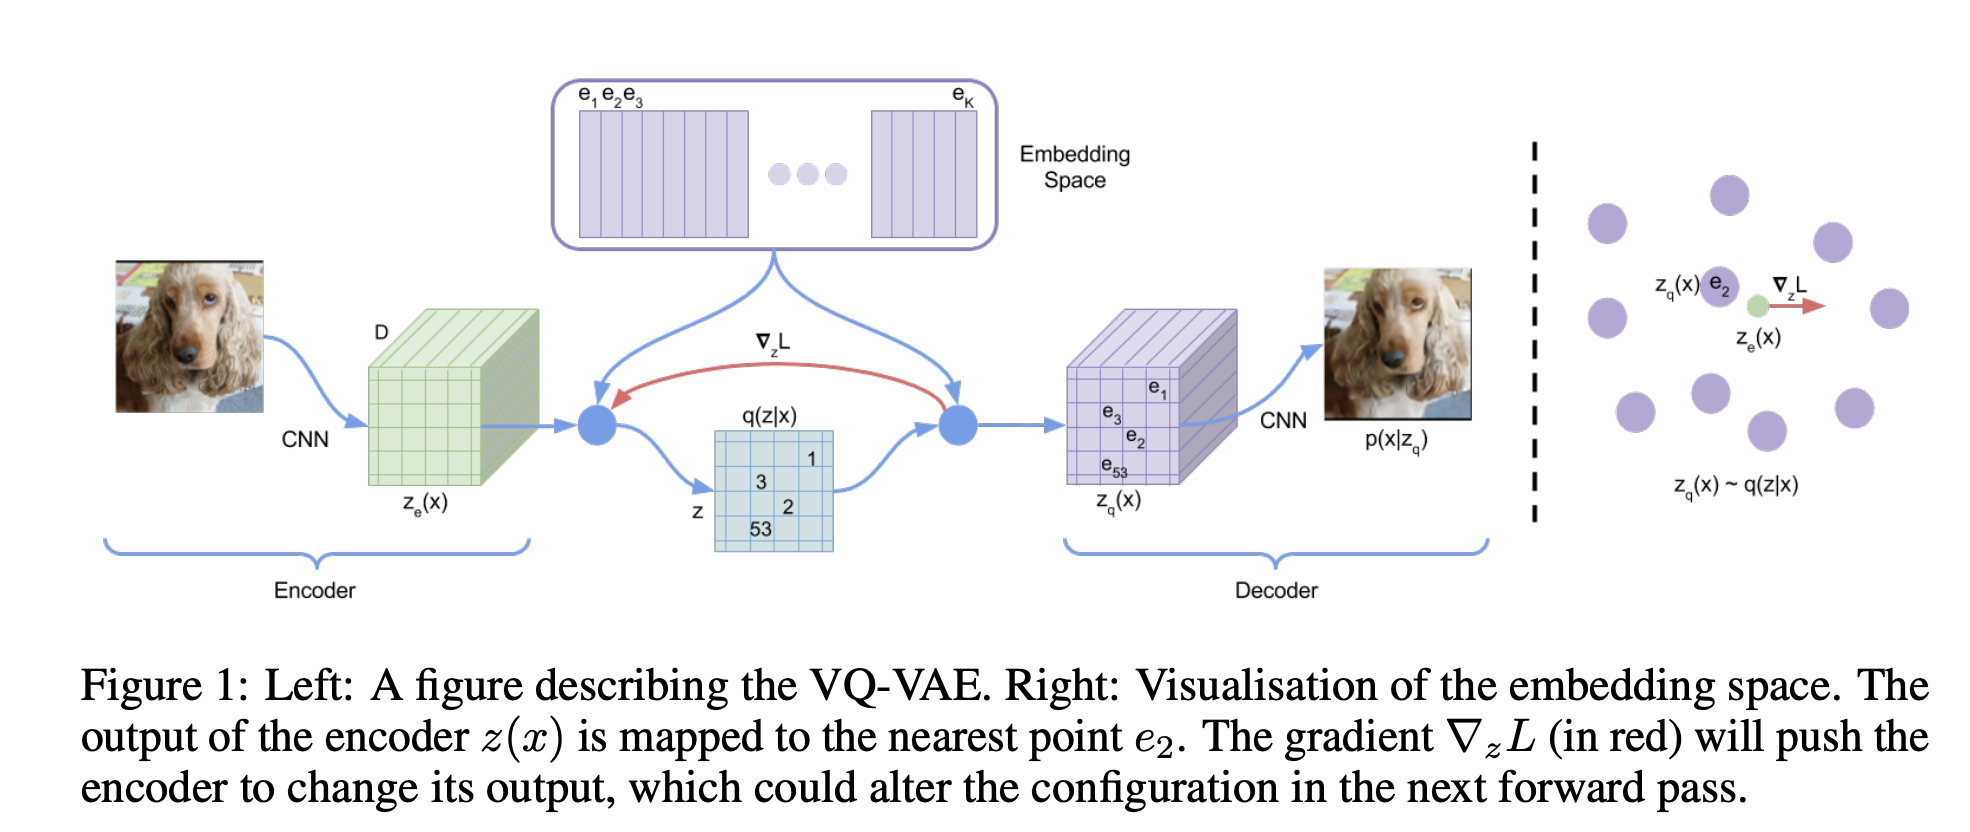

The parameters of the model to be optimized are the encoder, decoder, and the embedding space. We can calculate the gradients of the decoder and the embedding space, but the nearest neighbor search of the encoded vector to the embedded vector does not have a gradient. We get around this by directly passing the gradient of the decoder straight to the encoder. Since both the encoder and decoder use the same encoding space D (which is the size of each embedding vector), it contains some useful information for the encoder. 

Our loss function has to reflect our new parameters in the model. It is separated into three parts, the reconstruction loss, embedding loss, and commitment loss.

1.   The reconstruction loss is the same in the autoencoder and VAE, which is the difference between the input and output images. We want to minimize this to make our input and output as close as possible.
2.   The embedding loss is calculated from the difference between the embedding vectors and the encoded latent vectors. We stop the gradients of the latent vectors because we only want to optimize the embedding vectors. 
3.   The commitment loss is used to prevent the embedding space from growing arbitrarily large. We force the encoder to commit to embeddings because if it does not, the encoder can create encodings that do not make sense with the existing embeddings, so the embedding space would have to continue to grow to match the encodings. We stop the gradients of the embedding vectors to force the encoder to commit to embeddings. 

The decoder optimizes the first loss only, the encoder optimizes the first and third loss, and the embeddings optimize the middle loss. 


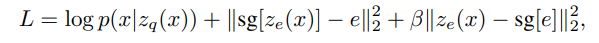

A prior can be trained from the discrete latents embeddings as a categorical distribution, and such can be made autoregressive by depending on past latent embeddings. While training the VQVAE, the prior should be kept constant and be based purely on the training inputs, but after training is completed, an autoregressive distribution can be used to generate novel data based on previous sampling. The authors of the VQVAE gave the example of PixelCNN and Wavenet, both being autoregressive models based on discrete data that can be fed embedding vectors and produce new embedding vectors that are then fed through the decoder into new data. However, since it is autoregressive and generally larger models, this project could not encompass them due to hardware limitations. 

### Model

#### Setup

In [ ]:
'''
from google.colab import drive
drive.mount('/content/drive')

%cd "/content/drive/MyDrive/Colab Notebooks/cse353-final/final"
%ls
'''

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/cse353-final/final
353_blogpost.ipynb  data/  models/


In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
#plt.rcParams['figure.dpi'] = 100

import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Encoder, Decoder, Vector Quantizer, Residual Block
---
We use .detach() in the forward function to backpropagate the decoder's gradients to the encoder

In [ ]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()

        self.K = num_embeddings
        self.D = embedding_dim
        self.beta = commitment_cost

        # create codebook of K embeddings each D long
        self.embedding = nn.Embedding(self.K, self.D)
        self.embedding.weight.data.uniform_(-1/self.K, 1/self.D)

    def forward(self, inputs):
        # convert input from B(atch), C(hannel), H(eight), W(idth) -> B,H,W,C
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape

        # flatten latent to B*H*W,C
        flat_input = inputs.view(-1, self.D)

        # compute L2 distance between latents and each embedding weights
        # distances.shape = B*H*W,embedding_dim
        distances = torch.cdist(flat_input, self.embedding.weight)

        # get nearest embedding, shape = B*H*W
        encoding_indices = torch.argmin(distances, dim=1)

        # quantize, shape = B,H,W,C
        quantized = torch.index_select(self.embedding.weight, 0, encoding_indices).view(input_shape)

        # calculate loss
        embedding_loss = F.mse_loss(inputs.detach(), quantized)
        commitment_loss = F.mse_loss(inputs, quantized.detach())
        loss = embedding_loss + self.beta * commitment_loss

        # straight through estimator
        # in forward, (inputs - inputs) cancel out to give quantized
        # but in backprop, detach() ignored so backprop inputs
        quantized = inputs + (quantized - inputs).detach()

        # convert quantized from B,H,W,C back to B,C,H,W
        quantized = quantized.permute(0, 3, 1, 2).contiguous()

        return quantized, loss


In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, num_hidden, num_residual_layers, num_residual_hidden):
        super(ResidualBlock, self).__init__()

        self.num_residual_layers = num_residual_layers
        self.layers = nn.ModuleList([
            nn.Sequential(
                nn.ReLU(True),
                nn.Conv2d(in_channels=num_hidden, out_channels=num_residual_hidden, kernel_size=3, stride=1, padding=1, bias=False),
                nn.ReLU(True),
                nn.Conv2d(in_channels=num_residual_hidden, out_channels=num_hidden, kernel_size=1, stride=1, bias=False)
                ) for _ in range(self.num_residual_layers)])
        
    def forward(self, x):
        for layer in self.layers:
            x = x + layer(x)
            return F.relu(x)
    

In [ ]:
class Encoder(nn.Module):
    def __init__(self, in_channels, num_hidden, num_residual_layers, num_residual_hidden):
        super(Encoder, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=num_hidden//2, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=num_hidden//2, out_channels=num_hidden, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=num_hidden, out_channels=num_hidden, kernel_size=3, stride=1, padding=1)
        self.res_block = ResidualBlock(num_hidden=num_hidden, num_residual_layers=num_residual_layers, num_residual_hidden=num_residual_hidden)

    def forward(self, x):
        ze = F.relu(self.conv1(x))
        ze = F.relu(self.conv2(ze))
        ze = self.conv3(ze)
        return self.res_block(ze)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, in_channels, num_hidden, num_residual_layers, num_residual_hidden):
        super(Decoder, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=num_hidden, kernel_size=3, stride=1, padding=1)
        self.res_block = ResidualBlock(num_hidden=num_hidden, num_residual_layers=num_residual_layers, num_residual_hidden=num_residual_hidden)
        self.convtrans3 = nn.ConvTranspose2d(in_channels=num_hidden, out_channels=num_hidden//2, kernel_size=4, stride=2, padding=1)
        self.convtrans4 = nn.ConvTranspose2d(in_channels=num_hidden//2, out_channels=3, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        zq = self.conv1(x)
        zq = self.res_block(zq)
        zq = F.relu(self.convtrans3(zq))
        return self.convtrans4(zq)

#### VQVAE Model

In [ ]:
class VQVAEModel(nn.Module):
    def __init__(self, num_hidden, num_residual_layers, num_residual_hidden, num_embeddings, embedding_dim, commitment_cost):
        """
        num_hidden: number of channels used in hidden convolutional layers
        num_residual_layers: number of residual layers per stack
        num_residual_hidden: number of channels used in residual hidden layers
        num_embeddings: number of embeddings in embedding table
        embedding_dim: the size of each embedding
        commitment_cost: beta value used in calculating (commitment) loss
        """
        super(VQVAEModel, self).__init__()

        self.encoder = Encoder(3, num_hidden, num_residual_layers, num_residual_hidden)
        self.pre_vq = nn.Conv2d(in_channels=num_hidden, out_channels=embedding_dim, kernel_size=1, stride=1)
        self.vq = VectorQuantizer(num_embeddings, embedding_dim, commitment_cost)
        self.decoder = Decoder(embedding_dim, num_hidden, num_residual_layers, num_residual_hidden)

    def forward(self, x):
        z = self.encoder(x)
        z = self.pre_vq(z)
        quantized, loss = self.vq(z)
        z = self.decoder(quantized)

        reconstruction_loss = F.mse_loss(z, x)
        loss = loss + reconstruction_loss

        return z, loss, reconstruction_loss


In [ ]:
def train_vqvae(model, data_loader, epochs, opt=None):
    if opt is None:
        opt = torch.optim.Adam(model.parameters())
    for epoch in range(epochs):
        train_loss = 0
        for idx, data in enumerate(data_loader):
            x, _ = data
            x = x.to(device)

            xhat, loss, _ = model(x)
            train_loss += loss.item()

            opt.zero_grad()
            loss.backward()
            opt.step()

            if idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch+1,
                    idx * len(x),
                    len(data_loader.dataset),
                    100. * idx / len(data_loader),
                    loss.item() / len(x)))
        print('====> Epoch: {} Average loss: {:.6f}'.format(
            epoch+1, train_loss / len(data_loader.dataset)))

### Hyperparameters

In [ ]:
batch_size = 256
epochs = 100

num_hidden = 128
num_residual_layers = 2
num_residual_hidden = 32
num_embeddings = 512
embedding_dim = 64
commitment_cost = 0.25

vqvae_PATH = 'vqvae_cifar10'

In [ ]:
data_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR10(
        root="./data", train=True, download=True,
        transform=torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))
            ])
        ), batch_size=batch_size, shuffle=True, pin_memory=True)


Files already downloaded and verified


### Run model

In [ ]:
model = VQVAEModel(num_hidden, num_residual_layers, num_residual_hidden, num_embeddings, embedding_dim, commitment_cost).to(device)
if os.path.isfile('./models/' + vqvae_PATH):
    model.load_state_dict(torch.load('./models/' + vqvae_PATH))
else:
    train_vae(model, data_loader, epochs)
    torch.save(model.state_dict(), './models/' + vqvae_PATH)

### Result

Loss: tensor(0.0161, device='cuda:0', grad_fn=<AddBackward0>)


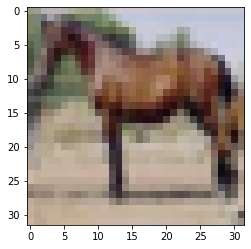

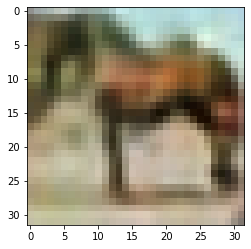

In [ ]:
(original, _) = next(iter(data_loader))
original = original[0].to(device)

x = original[None,:]

xhat, loss, _ = model(x)
print('Loss:', loss)

plt.imshow(np.transpose(x[0].cpu(), (1,2,0))+0.5)
plt.show()
plt.imshow(np.transpose(xhat[0].cpu().detach().numpy(), (1,2,0))+0.5)
plt.show()

This one performed better than the VAE likely because it was allowed to use a large codebook inside of the model, which allowed the latent vector to not need much space since it is just the index of the already trained embedded vectors. It was also discrete, so it did not have to take into account stochastic probabilities when generating the output image. 

While much larger and more complex, the basic concept of the VQVAE was a component in OpenAI's DALL-E, which was able to generate novel images based on input text data, which shows the potential of VQVAEs and VAEs in general. 

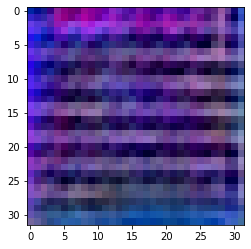

In [ ]:
(original, _) = next(iter(data_loader))
original = original[0].to(device)

x = original[None,:]
xx, _ = model.vq(model.pre_vq(model.encoder(x)))
new = torch.rand_like(xx)
#print(new)
xxx = model.decoder(new)

plt.imshow(np.transpose(xxx[0].cpu().detach().numpy(), (1,2,0))+0.5)
plt.show()

This shows the result of inputting a completely random prior, which shows that we do need a proper model to generate priors to input into the model to get new data outpu